In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')
import dask.dataframe as dd
import missingno as msno
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [2]:
#Always seed the randomness of this universe
np.random.seed(51)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%time
train_metadata_kaggle = dd.read_csv('mydata_train_metadata.csv')
test_metadata_kaggle = dd.read_csv('mydata_test_metadata.csv')
train_metadata_kaggle = train_metadata_kaggle.compute()
test_metadata_kaggle = test_metadata_kaggle.compute()
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 133) (3492890, 132)
CPU times: user 3min 42s, sys: 15.9 s, total: 3min 58s
Wall time: 2min 36s


In [5]:
"""%%time
f1_train = dd.read_csv('cesium_train_embeddings.csv')
f1_test = dd.read_csv('cesium_test_embeddings.csv')
f1_train = f1_train.compute()
f1_test = f1_test.compute()
print(f1_train.shape,f1_test.shape)"""

"%%time\nf1_train = dd.read_csv('cesium_train_embeddings.csv')\nf1_test = dd.read_csv('cesium_test_embeddings.csv')\nf1_train = f1_train.compute()\nf1_test = f1_test.compute()\nprint(f1_train.shape,f1_test.shape)"

In [6]:
"""%%time
train_metadata_kaggle = train_metadata_kaggle.merge(f1_train,how='left',on = 'object_id')
test_metadata_kaggle = test_metadata_kaggle.merge(f1_test,how='left',on = 'object_id')
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)"""

"%%time\ntrain_metadata_kaggle = train_metadata_kaggle.merge(f1_train,how='left',on = 'object_id')\ntest_metadata_kaggle = test_metadata_kaggle.merge(f1_test,how='left',on = 'object_id')\nprint(train_metadata_kaggle.shape,test_metadata_kaggle.shape)"

In [7]:
"""%%time
f2_train = dd.read_csv('myfeatures_train_embeddings.csv')
f2_test = dd.read_csv('myfeatures_test_embeddings.csv')
f2_train = f2_train.compute()
f2_test = f2_test.compute()
print(f2_train.shape,f2_test.shape)"""

"%%time\nf2_train = dd.read_csv('myfeatures_train_embeddings.csv')\nf2_test = dd.read_csv('myfeatures_test_embeddings.csv')\nf2_train = f2_train.compute()\nf2_test = f2_test.compute()\nprint(f2_train.shape,f2_test.shape)"

In [8]:
"""%%time
train_metadata_kaggle = train_metadata_kaggle.merge(f2_train,how='left',on = 'object_id')
test_metadata_kaggle = test_metadata_kaggle.merge(f2_test,how='left',on = 'object_id')
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)"""

"%%time\ntrain_metadata_kaggle = train_metadata_kaggle.merge(f2_train,how='left',on = 'object_id')\ntest_metadata_kaggle = test_metadata_kaggle.merge(f2_test,how='left',on = 'object_id')\nprint(train_metadata_kaggle.shape,test_metadata_kaggle.shape)"

In [9]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

In [10]:
temp = train_metadata_kaggle.copy()

In [11]:
y = temp['target']

In [12]:
del temp['target']

In [13]:
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [14]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)

In [15]:
temp.fillna(0.0, inplace=True)

In [16]:
ss = StandardScaler()
full_train_ss = ss.fit_transform(temp)

In [17]:
test_id = test_metadata_kaggle['object_id']

In [18]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [19]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [20]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [21]:
from keras.layers import PReLU, ReLU, Activation

In [22]:
K.clear_session()
def build_model(dropout_rate=0.25, activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    
    return model

In [23]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [24]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [25]:
#modify to work with kfold
#def smoteAdataset(Xig, yig, test_size=0.2, random_state=0):
def smoteAdataset(Xig_train, yig_train, Xig_test, yig_test):
    
        
    sm=SMOTE(random_state=51)
    Xig_train_res, yig_train_res = sm.fit_sample(Xig_train, yig_train.ravel())

        
    return Xig_train_res, pd.Series(yig_train_res), Xig_test, pd.Series(yig_test)

In [26]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

In [27]:
"""trn_xa, trn_y, val_xa, val_y=smoteAdataset(x_train.values, y_train.values, x_valid.values, y_valid.values)
x_train=pd.DataFrame(data=trn_xa, columns=x_train.columns)
x_valid=pd.DataFrame(data=val_xa, columns=x_valid.columns)"""

'trn_xa, trn_y, val_xa, val_y=smoteAdataset(x_train.values, y_train.values, x_valid.values, y_valid.values)\nx_train=pd.DataFrame(data=trn_xa, columns=x_train.columns)\nx_valid=pd.DataFrame(data=val_xa, columns=x_valid.columns)'

(6274, 131) (6274, 14) (1574, 131) (7848,)


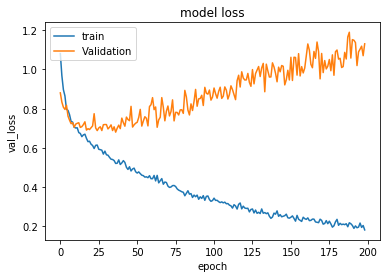

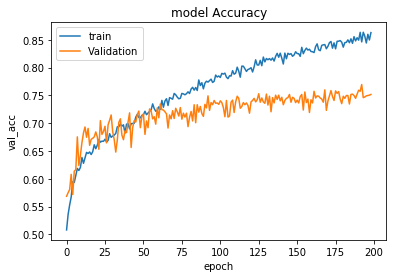

Loading Best Model
0.6869088105175679
(6276, 131) (6276, 14) (1572, 131) (7848,)


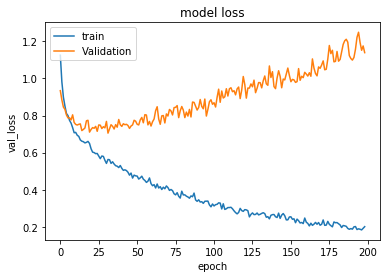

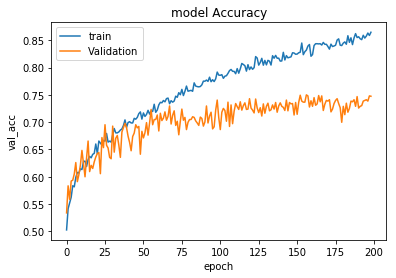

Loading Best Model
0.7115278577029892
(6277, 131) (6277, 14) (1571, 131) (7848,)


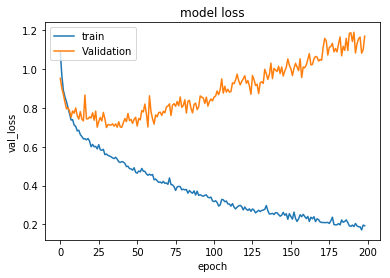

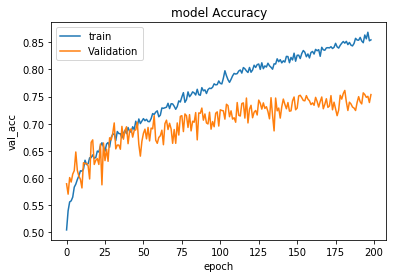

Loading Best Model
0.6911228888995108
(6281, 131) (6281, 14) (1567, 131) (7848,)


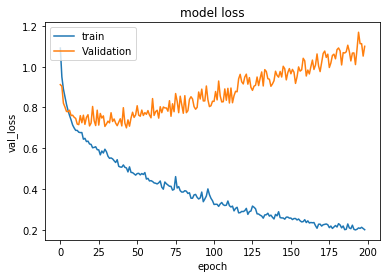

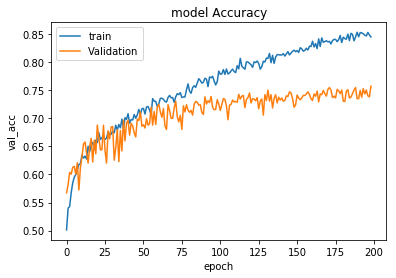

Loading Best Model
0.6946982993645028
(6284, 131) (6284, 14) (1564, 131) (7848,)


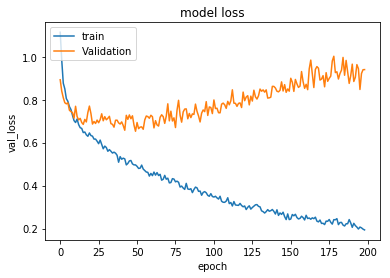

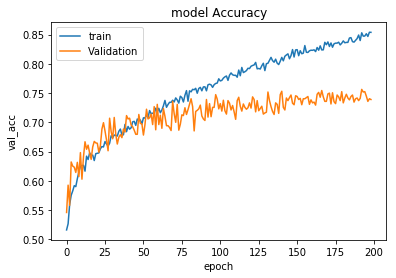

Loading Best Model
0.6524786043138829
MULTI WEIGHTED LOG LOSS : 0.68757 
CPU times: user 19min 17s, sys: 2min 4s, total: 21min 22s
Wall time: 25min 43s


In [28]:
%%time
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 200
batch_size = 100

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    #trn_xa, trn_y, val_xa, val_y=smoteAdataset(x_train, y_train, x_valid, y_valid)
    #x_train=pd.DataFrame(data=trn_xa, columns=x_train.columns)
    #x_valid=pd.DataFrame(data=val_xa, columns=x_valid.columns)
    print(x_train.shape,y_train.shape,x_valid.shape,y.shape)
    
    K.clear_session()
    model = build_model(dropout_rate=0.25, activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [29]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [31]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

46459

Normalized confusion matrix
[[9.34e-01 0.00e+00 6.62e-03 0.00e+00 0.00e+00 1.32e-02 0.00e+00 0.00e+00
  4.64e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 7.37e-01 0.00e+00 4.44e-02 3.23e-02 0.00e+00 4.04e-02 2.02e-02
  0.00e+00 3.43e-02 6.06e-03 6.46e-02 0.00e+00 2.02e-02]
 [3.25e-03 1.08e-03 9.83e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  4.33e-03 0.00e+00 1.08e-03 0.00e+00 7.58e-03 0.00e+00]
 [8.38e-04 9.81e-02 0.00e+00 3.00e-01 1.34e-01 0.00e+00 1.68e-01 2.18e-02
  0.00e+00 8.30e-02 1.68e-03 1.52e-01 0.00e+00 4.02e-02]
 [0.00e+00 2.73e-02 0.00e+00 1.20e-01 3.28e-01 0.00e+00 1.15e-01 1.64e-02
  0.00e+00 1.20e-01 0.00e+00 2.62e-01 0.00e+00 1.09e-02]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [2.07e-03 3.31e-02 0.00e+00 1.12e-01 8.88e-02 0.00e+00 4.24e-01 6.82e-02
  0.00e+00 1.84e-01 0.00e+00 6.82e-02 0.00e+00 2.07e-02]
 [0.00e+00 3.92e-02 0.00e+00 9.80e-03 0.00e+00 0.00e+00

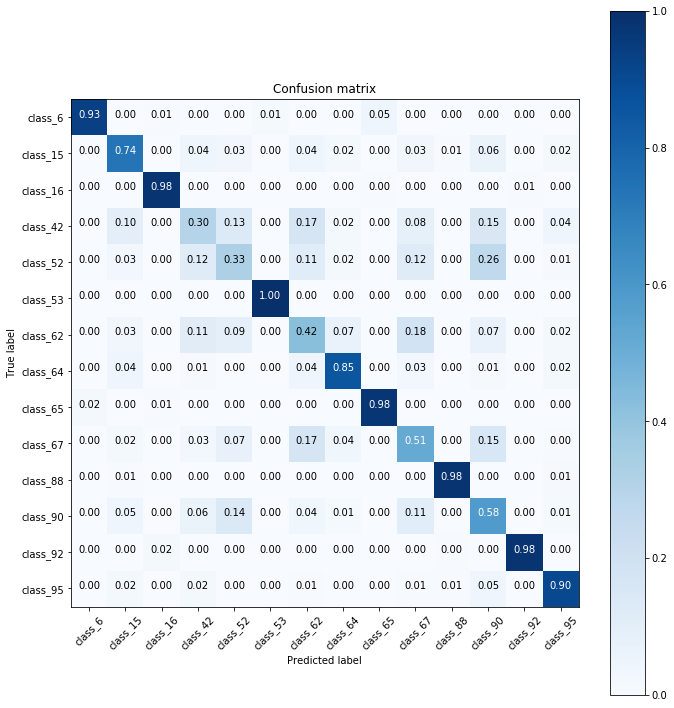

In [32]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [33]:
print(len(clfs))

5


In [34]:
%%time
temp_test = test_metadata_kaggle.copy()

CPU times: user 1.27 s, sys: 4.35 s, total: 5.62 s
Wall time: 5.62 s


In [35]:
del temp_test['object_id']

In [36]:
list(temp.columns) == list(temp_test.columns)

True

In [37]:
temp_test.fillna(0.0, inplace=True)

In [38]:
temp_test = ss.transform(temp_test)

In [39]:
gc.enable()
del train_metadata_kaggle,test_metadata_kaggle
gc.collect()

10824

In [40]:
%%time
test_pred0 = pd.DataFrame()
test_pred1 = pd.DataFrame()
test_pred2 = pd.DataFrame()
test_pred3 = pd.DataFrame()
test_pred4 = pd.DataFrame()

list_of_df = [test_pred0,test_pred1,test_pred2,test_pred3,test_pred4]

for num,c in enumerate(clfs):
    print(num)
    for k in range(0,len(temp_test),500000):
        test_pred = pd.DataFrame(c.predict_proba(temp_test[ k:k+500000] ))
        list_of_df[num] = pd.concat([list_of_df[num],test_pred],axis=0)
        del test_pred

0
1
2
3
4
CPU times: user 16min 29s, sys: 1min 54s, total: 18min 24s
Wall time: 10min 49s


In [41]:
test_pred2 = pd.DataFrame()
test_pred2 = (list_of_df[0] + list_of_df[1] + list_of_df[2] + list_of_df[3] + list_of_df[4])/5

In [42]:
print(test_pred2.shape)

(3492890, 14)


In [43]:
#test_pred2 = pd.DataFrame(np.random.rand(10,14))

In [44]:
test_pred2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.002197,0.000184,2.113901e-05,0.815990,0.037772,0.000253,0.109528,0.000074,2.390080e-04,0.009228,0.000093,0.020269,3.095760e-05,0.004121
1,0.000005,0.001522,8.636174e-08,0.128087,0.195219,0.000025,0.004634,0.000028,1.796981e-05,0.004396,0.000026,0.663875,4.997183e-07,0.002165
2,0.000006,0.000826,2.814347e-07,0.068097,0.090521,0.000082,0.002040,0.000059,9.388832e-06,0.009616,0.000348,0.802715,3.008611e-06,0.025678
3,0.000029,0.000779,4.677955e-06,0.043969,0.087756,0.000010,0.011976,0.000116,8.355281e-07,0.205079,0.000059,0.645515,7.868622e-07,0.004706
4,0.000008,0.000584,5.590261e-07,0.060463,0.233310,0.000194,0.007591,0.000010,2.174515e-05,0.036348,0.000010,0.659230,6.463112e-06,0.002225


In [45]:
temp_columns = ['object_id','class_6','class_15','class_16','class_42','class_52','class_53','class_62','class_64','class_65','class_67','class_88','class_90','class_92','class_95','class_99']

In [46]:
test_pred2.columns = temp_columns[1:15]

In [47]:
def getUnknown(data):
    return ((((((data["mymedian"]) + (((data["mymean"]) / 2.0)))/2.0)) + (((((1.0) - (((data["mymax"]) * (((data["mymax"]) * (data["mymax"]))))))) / 2.0)))/2.0)

feats = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53',
         'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90',
         'class_92', 'class_95']

In [48]:
klm = pd.DataFrame()
klm['mymean'] = test_pred2[feats].mean(axis=1)
klm['mymedian'] = test_pred2[feats].median(axis=1)
klm['mymax'] = test_pred2[feats].max(axis=1)

In [49]:
test_pred2['class_99'] = getUnknown(klm)

In [50]:
test_pred2.tail()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
492885,3.081703e-07,0.146408,9.768254e-06,0.172044,0.389466,0.000019,0.024191,0.000032,1.820067e-06,0.009230,0.002062,0.256361,0.000019,0.000156,0.244437
492886,1.598118e-06,0.021783,3.363275e-06,0.093983,0.334237,0.000050,0.021157,0.013277,7.074770e-08,0.047370,0.000245,0.465871,0.000010,0.002012,0.235562
492887,9.429017e-05,0.017123,1.144585e-06,0.613913,0.074891,0.000050,0.237817,0.000010,1.363668e-07,0.001297,0.000091,0.047304,0.000011,0.007397,0.201258
492888,1.340782e-06,0.810641,1.203152e-05,0.097667,0.014258,0.000021,0.007684,0.012383,2.839021e-05,0.000300,0.000141,0.054615,0.000082,0.002164,0.126060
492889,3.315595e-06,0.153674,3.170818e-07,0.251201,0.016124,0.000068,0.016949,0.000165,4.404130e-04,0.004725,0.000288,0.556177,0.000002,0.000185,0.216009


In [51]:
test_pred2 = test_pred2.reset_index(drop=True)

In [52]:
print(test_pred2.shape,test_id.shape)

(3492890, 15) (3492890,)


In [53]:
test_id.tail()

20052    130787966
20053    130787971
20054    130787974
20055    130788053
20056    130788054
Name: object_id, dtype: int64

In [54]:
test_id = test_id.reset_index(drop=True)

In [55]:
test_id.index == test_pred2.index

array([ True,  True,  True, ...,  True,  True,  True])

In [56]:
%%time
test_pred = pd.concat([test_id,test_pred2],axis=1)

CPU times: user 43.5 ms, sys: 82.6 ms, total: 126 ms
Wall time: 125 ms


In [57]:
test_pred = test_pred[temp_columns]

In [58]:
test_pred.head()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.002197,0.000184,2.113901e-05,0.815990,0.037772,0.000253,0.109528,0.000074,2.390080e-04,0.009228,0.000093,0.020269,3.095760e-05,0.004121,0.123405
1,14,0.000005,0.001522,8.636174e-08,0.128087,0.195219,0.000025,0.004634,0.000028,1.796981e-05,0.004396,0.000026,0.663875,4.997183e-07,0.002165,0.185975
2,17,0.000006,0.000826,2.814347e-07,0.068097,0.090521,0.000082,0.002040,0.000059,9.388832e-06,0.009616,0.000348,0.802715,3.008611e-06,0.025678,0.129768
3,23,0.000029,0.000779,4.677955e-06,0.043969,0.087756,0.000010,0.011976,0.000116,8.355281e-07,0.205079,0.000059,0.645515,7.868622e-07,0.004706,0.191796
4,34,0.000008,0.000584,5.590261e-07,0.060463,0.233310,0.000194,0.007591,0.000010,2.174515e-05,0.036348,0.000010,0.659230,6.463112e-06,0.002225,0.187403


In [59]:
print(test_pred.shape)

(3492890, 16)


In [60]:
%%time
test_pred.to_csv('test_pred_28.csv',index=False)

CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 17s


In [ ]:
#!kaggle competitions submit -c PLAsTiCC-2018 -f test_pred_21.csv -m "Message"